In [128]:
import gdown as gdown
import pulp as pulp

import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
import numpy as np



df = pd.read_csv("turni1.csv", index_col=0)
df


Shift 1 Shift 2 Shift 3 Shift 4  Lavoratori RIchiesti
TurniOrari                                                                   
6:00-9:00                     X     NaN     NaN       X                  10.0
9:00-12:00                    X     NaN     NaN     NaN                   6.0
12:00-15:00                   X       X     NaN     NaN                  15.0
15:00-18:00                 NaN       X     NaN     NaN                   9.0
18:00-21:00                 NaN       X       X     NaN                   5.0
21:00-24:00                 NaN     NaN       X     NaN                   2.0
24:00-3:00                  NaN     NaN       X       X                   8.0
3:00-6:00                   NaN     NaN     NaN       X                   7.0
Wage rate per shift ($)     100     100     100     100                   NaN

In [129]:
df = df.fillna(0).applymap(lambda x: 1 if x == "X" else x)

df
a = df.drop(index=["Wage rate per shift ($)"], columns=["Lavoratori RIchiesti"]).values
a

array([[1, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 1]], dtype=object)

In [130]:
# Input parameters
#n=numero di shift
#shape è un metodo di numpy, shape[1] restituisce il numero delle colonne, shape[0] restituisce il numero delle righe
n = a.shape[1]
n

4

In [131]:
#T = numero di finestre temporali
T = a.shape[0]
#dt = numero di lavoratori richiesti per finestra temporale
d = df["Lavoratori RIchiesti"].values
#wj = stipendio per shift che nel nostro caso non varia(sempre = 100)
#loc[] accede a un gruppo di righe o colonne
w = df.loc["Wage rate per shift ($)", :].values.astype(int)


# Create problem, LpMinimize minimizza il costo dei salari pagati a tutti i lavoratori
#serve per creare un problema di minimizzazione
#lpProblem = classe contenitore per un problema di LP
prob = LpProblem("scheduling_workers", LpMinimize)

# Decision variables (yj in tale caso, cioè il numero di lavoratori)
#LpVariable.dicts(name, list_of_variables, lowBound, upBound, cat)
#name = nome della variabile;
#lowBound = limite inferiore dell'intervallo di questa variabile;
#upBound = limite superiore dell'intervallo di questa variabile;
#cat = categoria in cui si trova la variabile(integer o binary)
#dato che ho a che fate con il numero dei lavoratori per turno di lavoro, devo indicare che la variabile è un numero intero e che deve essere maggiore di 0
#LpVariable = variabili aggiunte ai vincoli nell'LP
y = LpVariable.dicts("num_workers", list(range(n)), lowBound=0, cat="Integer")
y

scheduling_workers:
MINIMIZE
None
VARIABLES

In [132]:
#FORMULAZIONE
# Objective (ridurre al minimo la quantità di denaro spesa pe tutti i lavoratori in un giorno che si traduce nell'inserimento del minor numero di lavoratori in un giorno nel nostro caso perchè si è deciso di non diversificare la tariffa per ogni turno come nell'esempio)
# wj = stipendio per shift
# yj = numero lavoratori per shift
# n=4 che è numero di shift
#serve per aggiungere la funzione obiettivo
#lpSum() dato un elenco costruisce una funzione
# lineare da usare come vincolo o variabile
prob += lpSum([w[j] * y[j] for j in range(n)])


# Subject to (ridurre al minimo la quantità di denaro spesa pe tutti i lavoratori in un turno che si traduce nell'inserimento del minor numero di lavoratori in un turno nel nostro caso perchè si è deciso di non diversificare la tariffa per ogni turno come nell'esempio)
# T = numero di finetre temporali = 8
# a[t,j] = matrice che indica lo spostamento associato
# a ogni finestra temporale
#d[t] = numero lavoratori richiesti per finestra temporale
for t in range(T):
 # (prob += .... >=) serve per aggiungere un vincolo
 #lpSum -> calcola la somma di un elenco di espressioni lineari
    prob += lpSum([a[t, j] * y[j] for j in range(n)]) >= d[t]



#Solve(trova la soluzione del problema)
prob.solve()

1
#LpStatus[status] serve per visualizzare lo stato della soluzione
print("Status:", LpStatus[prob.status])

#Se lo stato è OPTIMAL significa che le soluzioni ottimali esistono e il risolutore le ha trovate.
#Ci sono altri stati possibili: Not Solved, Infeasible, Unbounded, Undfined

Status: Optimal


In [133]:


#Status: Optimal
numeroTurno =[]
numeroLavoratori = []

#serve per vedere le soluzioni ottimali
for shift in range(n):
    print(
        f"The number of workers needed for shift {shift} is {int(y[shift].value())} workers"
    )
    numeroLavoratori.append(int(y[shift].value()))
    numeroTurno.append(shift)
   # numeroLavoratori.append(int(y[shift].value()))


The number of workers needed for shift 0 is 6 workers
The number of workers needed for shift 1 is 9 workers
The number of workers needed for shift 2 is 2 workers
The number of workers needed for shift 3 is 7 workers


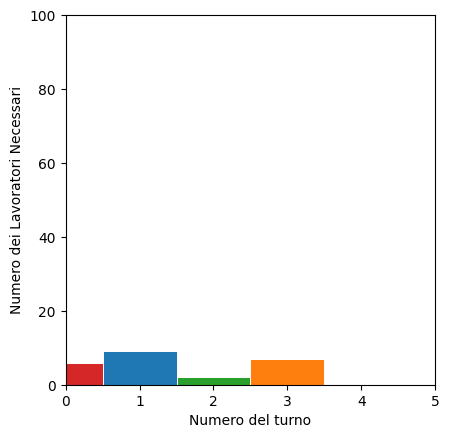

In [134]:

#numeroLavoratori=prezzoDurata.iloc[:,2:3]
fig1, ax = plt.subplots()

ax.set_xlim(0,5)
ax.set_ylim(0,100)
ax.set_xlabel("Numero del turno")
ax.set_ylabel("Numero dei Lavoratori Necessari")
#ax.set_visible("gsdgs")

ax.set_box_aspect(1)

bar_labels = ['TURNO 1', 'TURNO 2', 'TURNO 3', 'TURNO 4']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(numeroTurno, numeroLavoratori, width=1, edgecolor="white", linewidth=0.7, label=bar_labels, color=bar_colors)


ax.set(
       ylim=(0, 100), )

plt.show()

In [135]:

print(
    f"The total amount of money being paid to workers in 4 shifts are ${value(prob.objective)}",
)


The total amount of money being paid to workers in 4 shifts are $2400.0
